# 📊 **Data Analysis of CARM Test Flight #5**

### *A compilation of graphs generated from Test Flight #5's flight data*

---

**Author(s):** Nico Moldovean, Daniel Opara

## **Background**

Test Flight 5 used the Scallion Pancakes for data collection. All of the data was collected using breakout boards. There are two files, one generated by each flight computer, that contain the flight data:
* `carmf5_HIGHDATA.CSV`
* `carmf5_LOWDATA.CSV`

`carmf5_HIGHDATA.CSV` contains data where the accelerometer has its range set to [-16, 16] Gs and its gyroscope set to [-500, 500] degrees per second. However, misleading as the Adafruit documentation is, it actually records in radians so the range is more so [-8.726646, 8.726646] radians per second.

In a similar manner, `carmf5_LOWDATA.CSV` contains data where the accelerometer has its range set to [-8, 8] Gs and its gyroscope set to [-245, 245] degrees per second, thus [-4.276057, 4.276057] radians per second.

For more information on the hardware used, please see our wiki:

https://sedstufts.notion.site/3bce0b81e5c64006974c05a38ad85014?v=dadb10bf25164fb6b814ad583a3c459f

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as s_stats
import seaborn as sns
import mplcursors

In [12]:
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind', 
              font='sans-serif', font_scale=1, color_codes=True, rc=None) 
palette = sns.color_palette("colorblind")

In [13]:
# Read CSV files
high_launch_data = pd.read_csv('data/carmf5_HIGHDATA.CSV')
low_launch_data = pd.read_csv('data/carmf5_LOWDATA.CSV')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_41932\3832910632.py:2: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  high_launch_data = pd.read_csv('data/carmf5_HIGHDATA.CSV')
C:\Users\Daniel\AppData\Local\Temp\ipykernel_41932\3832910632.py:3: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  low_launch_data = pd.read_csv('data/carmf5_LOWDATA.CSV')


In [29]:
# converting seconds to milliseconds
HIGH_LAUNCH_START = 1660 * 1000
HIGH_LAUNCH_END = 1733 * 1000
LOW_LAUNCH_START = 1731 * 1000
LOW_LAUNCH_END = 1810 * 1000

# doing some data cleansing to trim out parts of the data that doeesn't matter
filtered_high_df = high_launch_data[(high_launch_data['time (ms)'] >= HIGH_LAUNCH_START) & (high_launch_data['time (ms)'] <= HIGH_LAUNCH_END)]
filtered_low_df = low_launch_data[(low_launch_data['time (ms)'] >= LOW_LAUNCH_START) & (low_launch_data['time (ms)'] <= LOW_LAUNCH_END)]

# scaling down time to make it start at t=0
first_high = filtered_high_df['time (ms)'].iloc[0]
first_low = filtered_low_df['time (ms)'].iloc[0]
filtered_high_df['time (ms)'] = filtered_high_df['time (ms)'] - first_high
filtered_low_df['time (ms)'] = filtered_low_df['time (ms)'] - first_low

C:\Users\Daniel\AppData\Local\Temp\ipykernel_41932\217025360.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_high_df['time (ms)'] = filtered_high_df['time (ms)'] - first_high
C:\Users\Daniel\AppData\Local\Temp\ipykernel_41932\217025360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_low_df['time (ms)'] = filtered_low_df['time (ms)'] - first_low


Let's start by plotting the altitude data. We have two rows in the csv that contain altitude data—one that contains the raw output from the barometer and one that calculates a zero offset from the raw data to ensure that we have our altitude at 0 at the start of launch. And just to hone this point home, here's both of these columns graphed together.

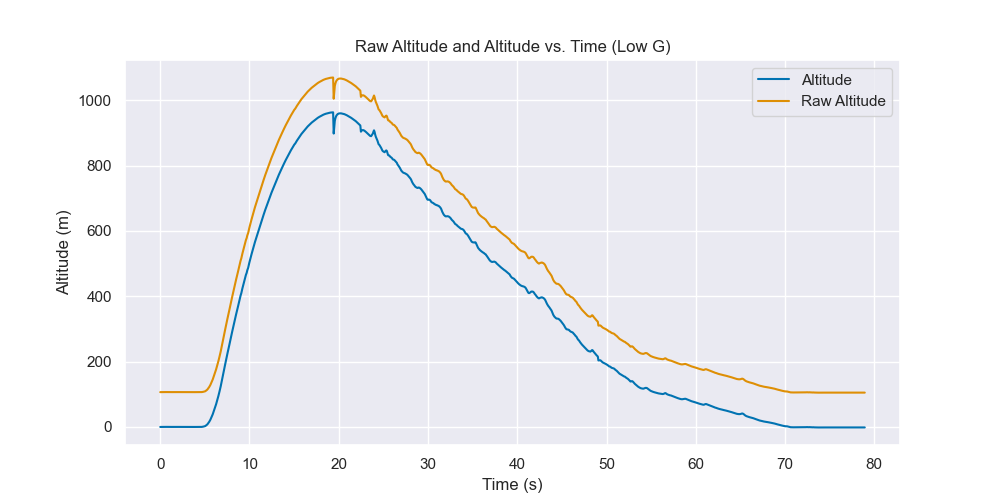

In [46]:

fig, ax = plt.subplots(figsize=(10, 5))
altvtime = ax.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['altitude (m)'], label='Altitude')
raw_altvtime = ax.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['raw altitude (m)'], label='Raw Altitude')
ax.legend(loc='upper right', fontsize='small', title='Legend')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Altitude (m)')
ax.set_title('Raw Altitude and Altitude vs. Time (Low G)')
plt.legend()
plt.show()


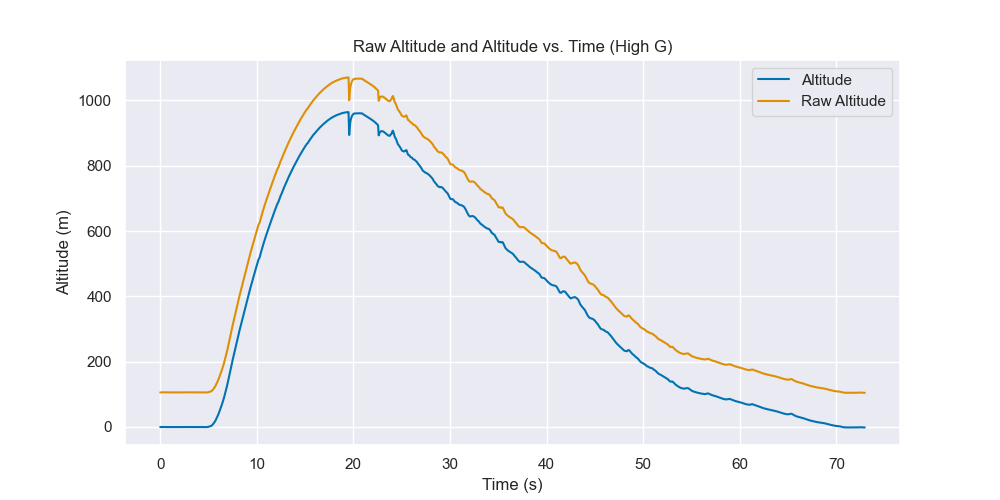

In [45]:

fig, ax = plt.subplots(figsize=(10, 5))
altvtime = ax.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['altitude (m)'], label='Altitude')
raw_altvtime = ax.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['raw altitude (m)'], label='Raw Altitude')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Altitude (m)')
ax.set_title('Raw Altitude and Altitude vs. Time (High G)')
plt.legend()
plt.show()

As you can see, the graphs practically the same across each flight computer.

Moving on, let's take a look at some temperature graphs. The flight computer had two means of detecting temperature: one was with our dedicated temperature sensor breakout board and the other was with the barometer. Bosch barometers often integrate a temperature sensor in there as well so we thoughgt we might as well grab the data from and see how well they perform.

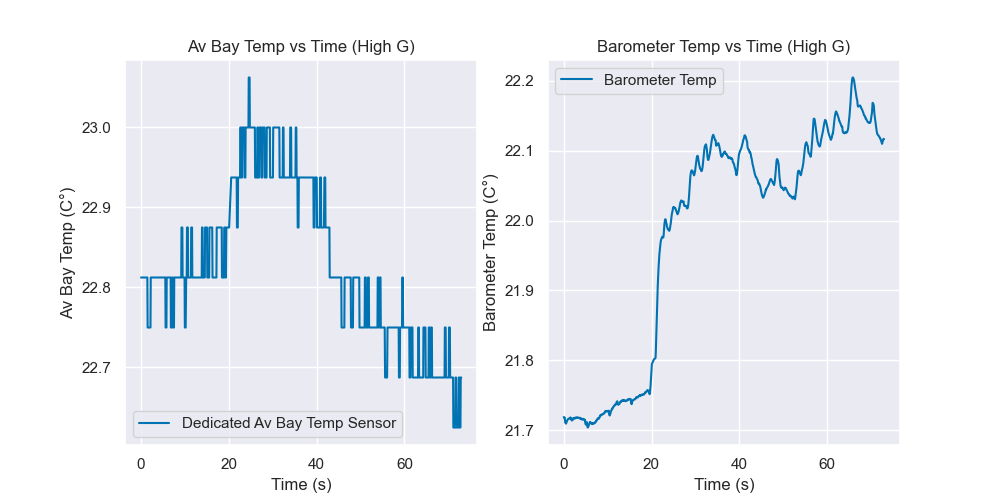

In [35]:
# Av bay temp sensor vs time and barometer temp vs time (High g)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# first subplot
ax1.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['av bay temperature (C)'], label='Dedicated Av Bay Temp Sensor')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Av Bay Temp (C°)')
ax1.set_title('Av Bay Temp vs Time (High G)')
ax1.legend()

# second subplot
ax2.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['barometer temp (C)'], label='Barometer Temp')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Barometer Temp (C°)')
ax2.set_title('Barometer Temp vs Time (High G)')
ax2.legend()
plt.show()


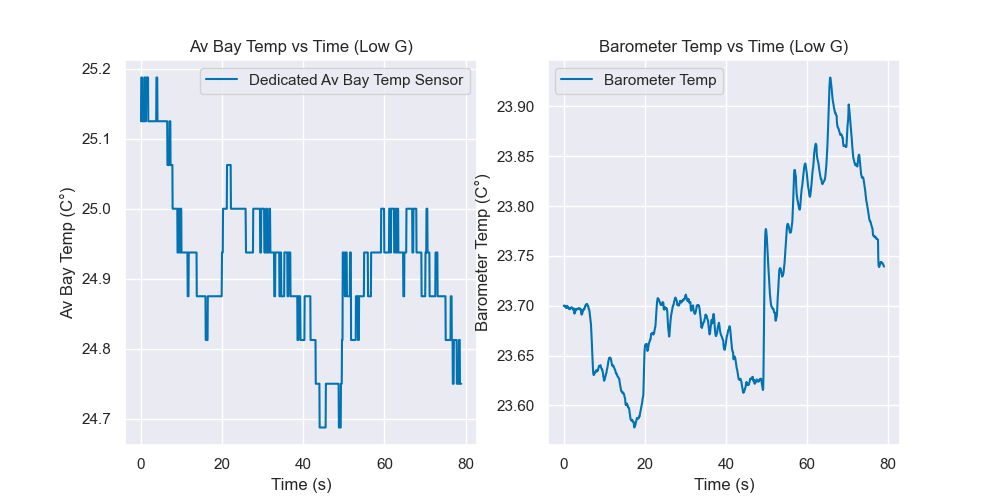

In [36]:
# Av bay temp sensor vs time and barometer temp vs time (High g)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# first subplot
ax1.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['av bay temperature (C)'], label='Dedicated Av Bay Temp Sensor')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Av Bay Temp (C°)')
ax1.set_title('Av Bay Temp vs Time (Low G)')
ax1.legend()

# second subplot
ax2.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['barometer temp (C)'], label='Barometer Temp')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Barometer Temp (C°)')
ax2.set_title('Barometer Temp vs Time (Low G)')
ax2.legend()
plt.show()

Now let's compare acceleration of each axis between the low G and high G data.

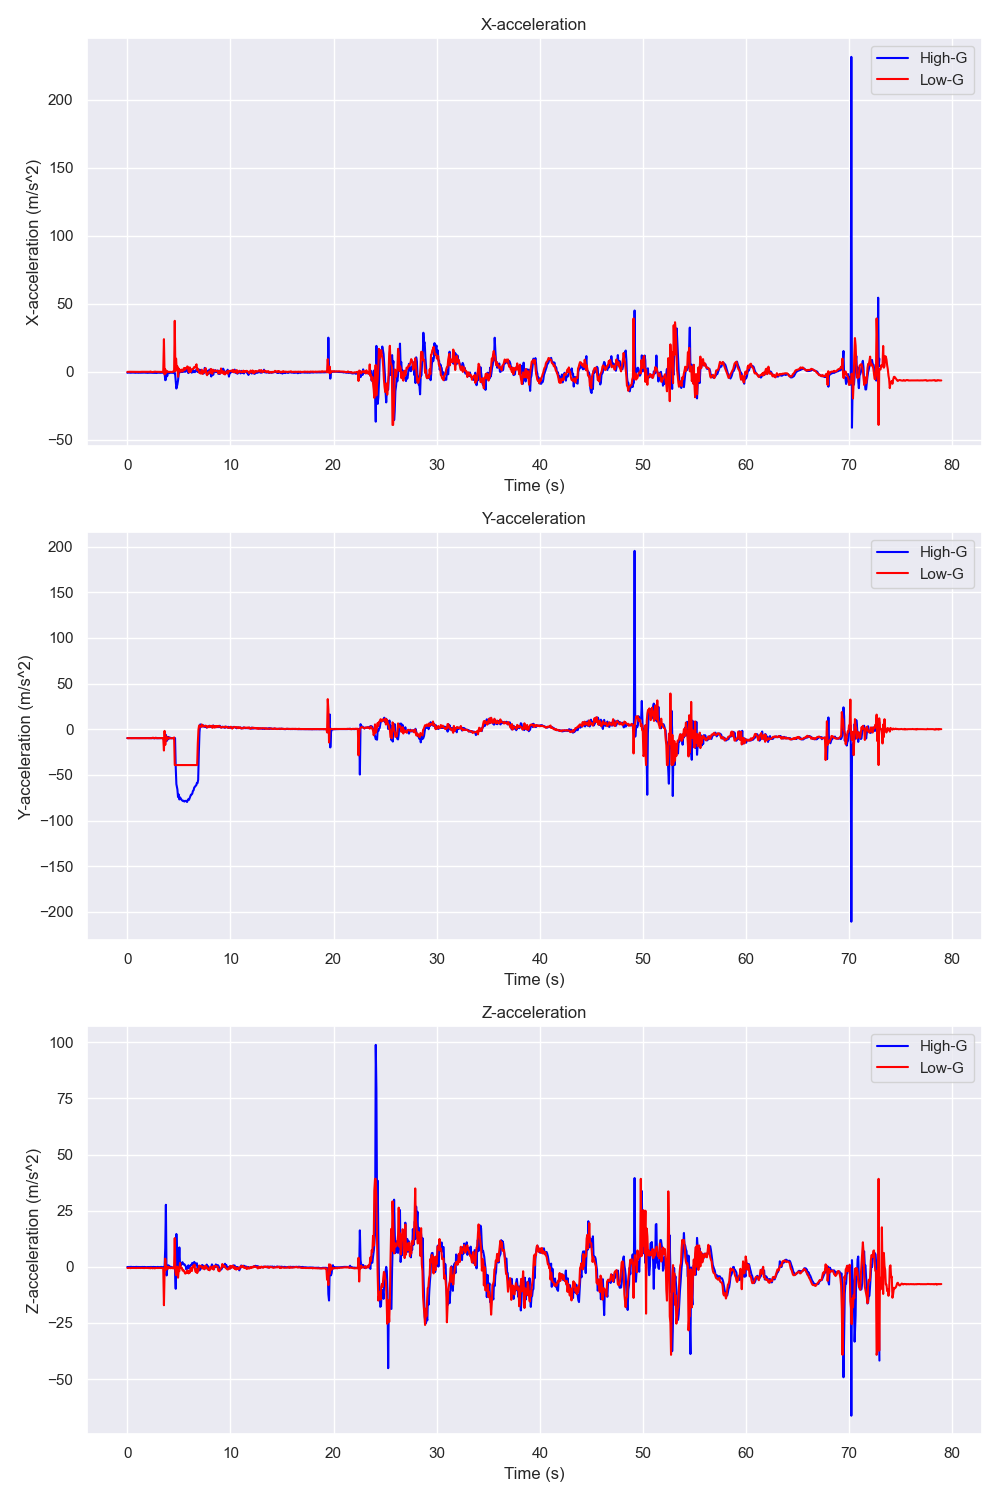

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# x-acceleration on the first subplot
ax1.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['x acceleration (m/s^2)'], label='High-G', color='blue')
ax1.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['x acceleration (m/s^2)'], label='Low-G', color='red')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('X-acceleration (m/s^2)')
ax1.set_title('X-acceleration')
ax1.legend()

# y-acceleration on the second subplot
ax2.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['y acceleration (m/s^2)'], label='High-G', color='blue')
ax2.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['y acceleration (m/s^2)'], label='Low-G', color='red')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Y-acceleration (m/s^2)')
ax2.set_title('Y-acceleration')
ax2.legend()

# z-acceleration on the third subplot
ax3.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['z acceleration (m/s^2)'], label='High-G', color='blue')
ax3.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['z acceleration (m/s^2)'], label='Low-G', color='red')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Z-acceleration (m/s^2)')
ax3.set_title('Z-acceleration')
ax3.legend()

plt.tight_layout()
plt.show()


Let's also see what the acceleration looks like on one graph

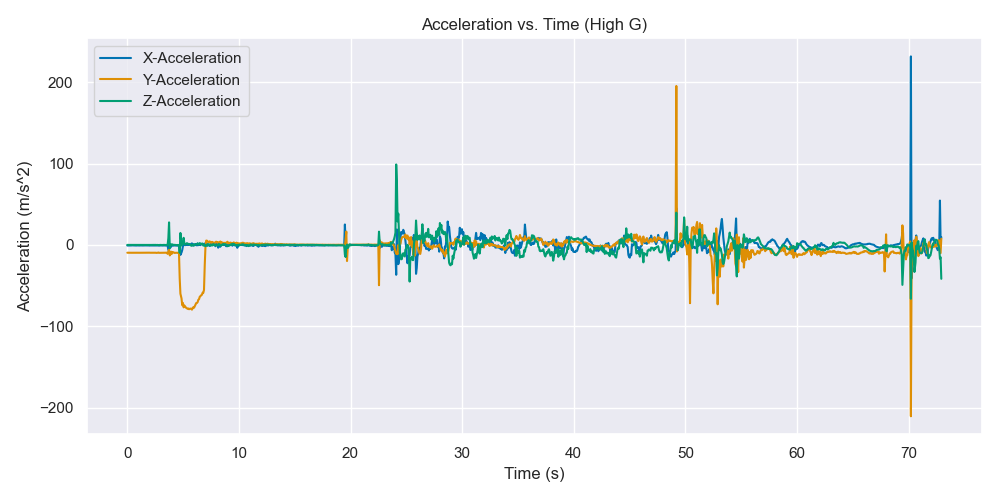

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['x acceleration (m/s^2)'], label='X-Acceleration')
ax.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['y acceleration (m/s^2)'], label='Y-Acceleration')
ax.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['z acceleration (m/s^2)'], label='Z-Acceleration')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration (m/s^2)')
ax.set_title('Acceleration vs. Time (High G)')
plt.legend()
plt.tight_layout()
plt.show()

Let's do the same with gyroscope readings

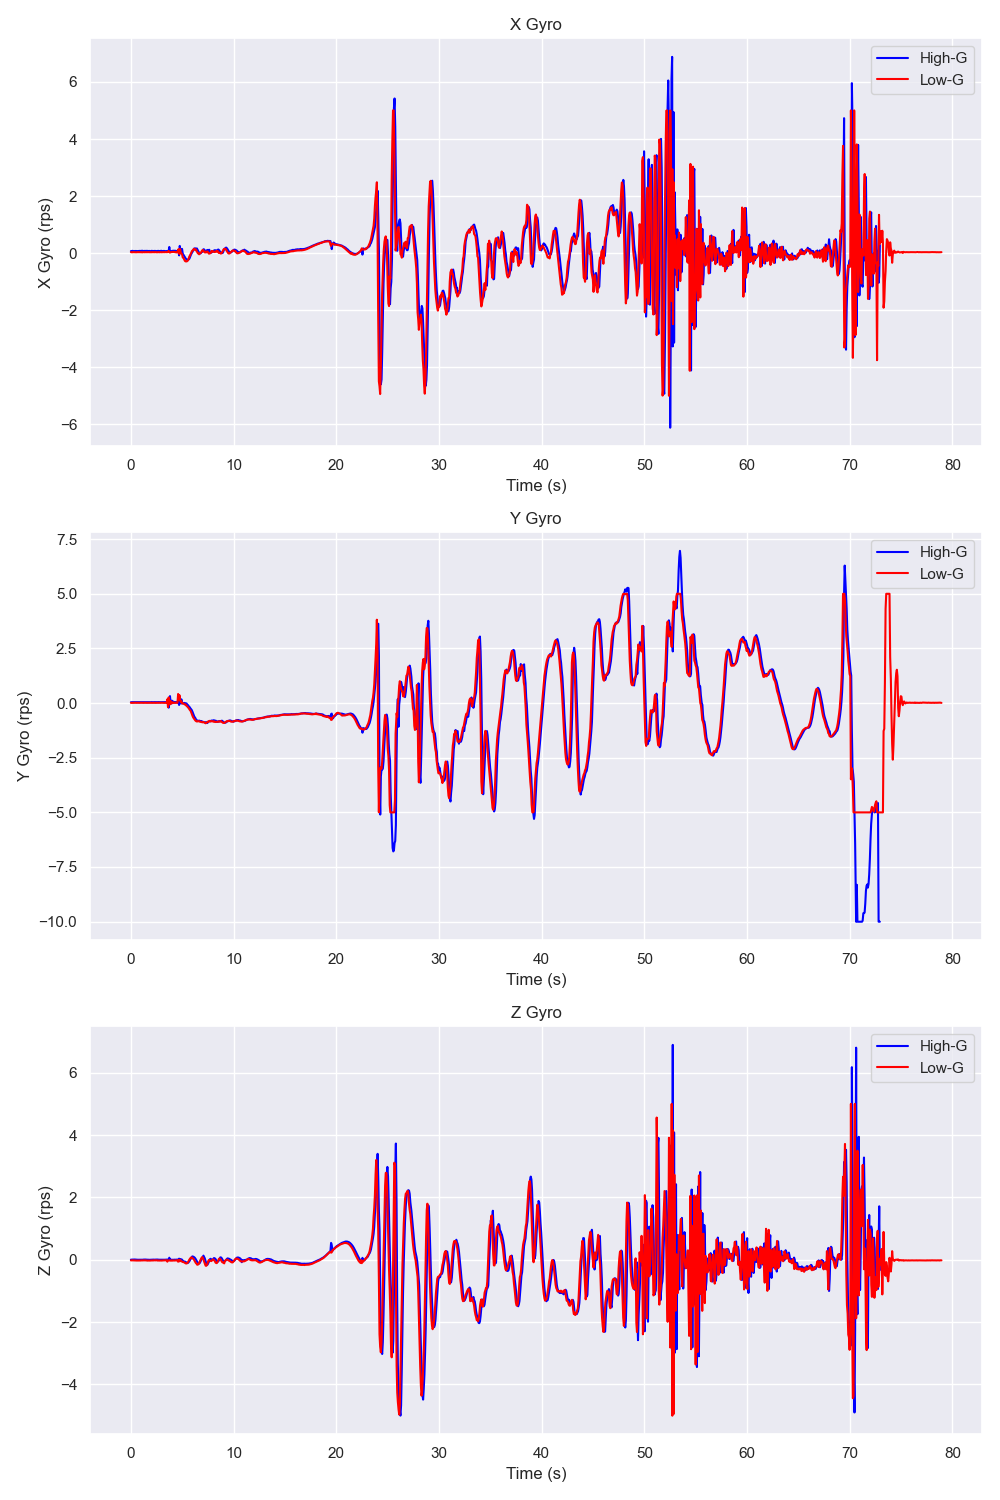

In [40]:
# Gyroscope readings (High and Low g)
# Create a figure with three vertically stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# x gyro on the first subplot
ax1.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['x gyro (dps)'], label='High-G', color='blue')
ax1.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['x gyro (dps)'], label='Low-G', color='red')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('X Gyro (rps)')
ax1.set_title('X Gyro')
ax1.legend()

# y gyro on the second subplot
ax2.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['y gyro (dps)'], label='High-G', color='blue')
ax2.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['y gyro (dps)'], label='Low-G', color='red')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Y Gyro (rps)')
ax2.set_title('Y Gyro')
ax2.legend()

# z gyro on the third subplot
ax3.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['z gyro (dps)'], label='High-G', color='blue')
ax3.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['z gyro (dps)'], label='Low-G', color='red')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Z Gyro (rps)')
ax3.set_title('Z Gyro')
ax3.legend()

plt.tight_layout()
plt.show()


Let's also take a look at what thew magnometer was reading

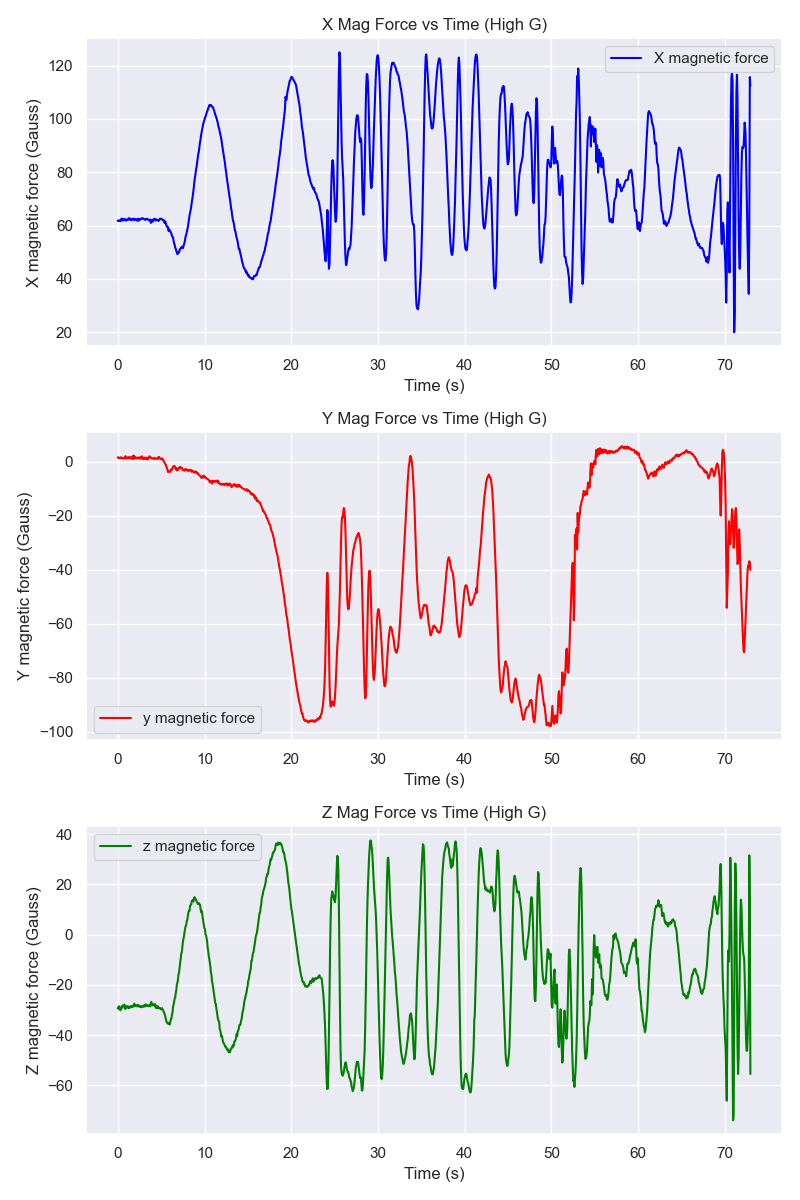

In [42]:
# Create a figure with three vertically stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

ax1.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['x magnetic force (gauss)'], label='X magnetic force', color='blue')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('X magnetic force (Gauss)')
ax1.set_title('X Mag Force vs Time (High G)')
ax1.legend()

ax2.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['y magnetic force (gauss)'], label='y magnetic force', color='red')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Y magnetic force (Gauss)')
ax2.set_title('Y Mag Force vs Time (High G)')
ax2.legend()

ax3.plot(filtered_high_df['time (ms)'] / 1000, filtered_high_df['z magnetic force (gauss)'], label='z magnetic force', color='green')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Z magnetic force (Gauss)')
ax3.set_title('Z Mag Force vs Time (High G)')
ax3.legend()

plt.tight_layout()
plt.show()


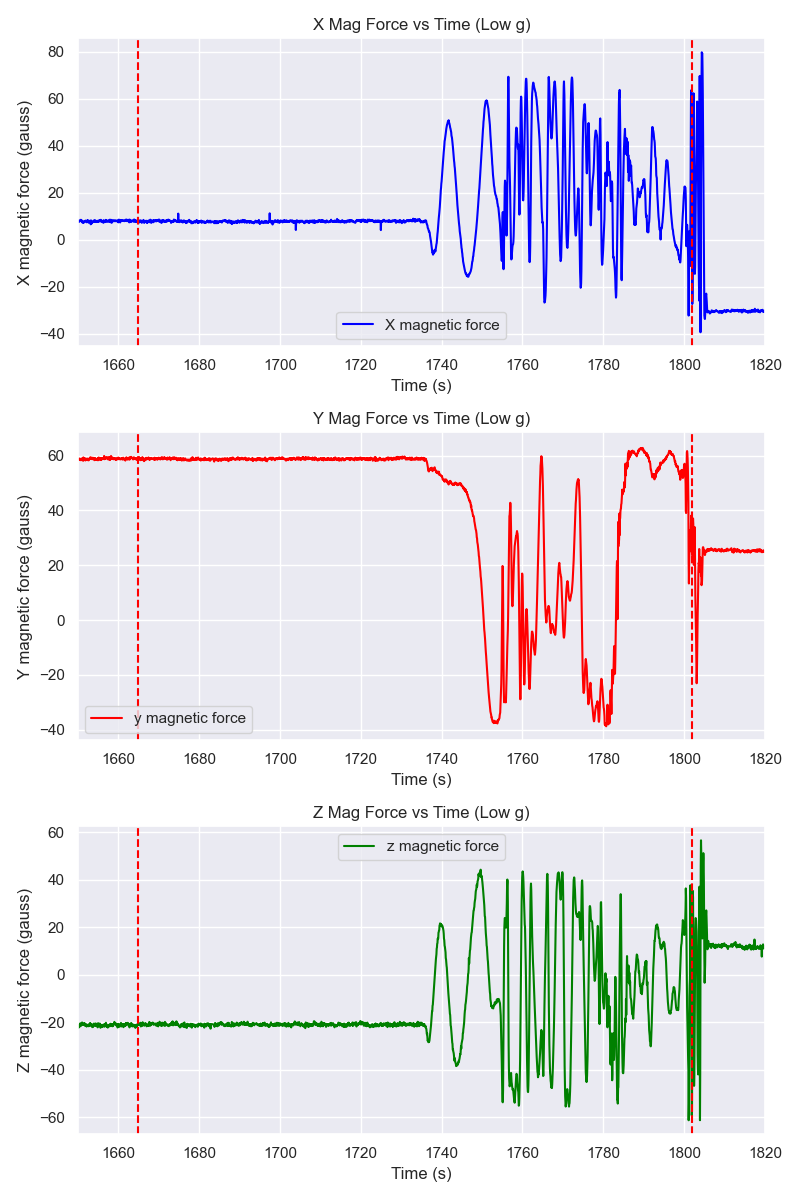

In [11]:
# Create a figure with three vertically stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

ax1.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['x magnetic force (gauss)'], label='X magnetic force', color='blue')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('X magnetic force (Gauss)')
ax1.set_title('X Mag Force vs Time (High G)')
ax1.legend()

ax2.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['y magnetic force (gauss)'], label='y magnetic force', color='red')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Y magnetic force (Gauss)')
ax2.set_title('Y Mag Force vs Time (High G)')
ax2.legend()

ax3.plot(filtered_low_df['time (ms)'] / 1000, filtered_low_df['z magnetic force (gauss)'], label='z magnetic force', color='green')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Z magnetic force (Gauss)')
ax3.set_title('Z Mag Force vs Time (High G)')
ax3.legend()

plt.tight_layout()
plt.show()
